In [1]:
import xarray as xr
import numpy as np
import torch
import pytorch_lightning as pl
import torch.nn as nn
#import xrft
import matplotlib.pyplot as plt
#import pandas as pd
from tqdm import tqdm
import os
import glob
from pathlib import Path
from typing import Union, List
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import torch.nn.functional as F
import cartopy.crs as ccrs
import pickle
import copy
import yaml
import hydra
from IPython.display import Markdown, display
from omegaconf import OmegaConf
from sklearn.metrics import accuracy_score

In [2]:
from src.utils import load_ssf_ecs_da, load_ssf_ecs_classif_da, get_depth_array, get_config_file_path_from_ckpt_path, get_cfg_from_from_ckpt_path
from src.data import  BaseDatamodule, BaseDatamodule_ecs_classif
from src.acoustic_predictor_V2 import  AcousticPredictor
from src.ecs_classification import ECS_classification
from src.autoencoder import AutoEncoder

In [3]:
pl.seed_everything(333)

Seed set to 333


333

In [4]:
plt.style.use('ggplot')

save_fig = False

In [5]:
sound_speed_path = "/DATASET/eNATL/eNATL60_BLB002_sound_speed_regrid_0_1000m.nc"
ecs_path = "/DATASET/envs/o23gauvr/tmp/eNATL60_BLB002_ECS_at_0_regrid_0_1000m.nc"
ecs_classif_path = "/DATASET/envs/o23gauvr/tmp/eNATL60_BLB002_ECS_binary_classification_at_0_regrid_0_1000m.nc"

In [6]:
ss_da = xr.open_dataarray(sound_speed_path)
ecs_da = xr.open_dataset(ecs_path)['ecs']

In [6]:
x_min = 1459.0439165829073
x_max = 1545.8698054910844

In [7]:
gpu = None
    
if torch.cuda.is_available() and gpu is not None:
##This may not be necessary outside the notebook
    dev = f"cuda:{gpu}"
else:
    dev = "cpu"

device = torch.device(dev)



In [ ]:
ae_path = "/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_without_AP/20_60_dense_avgpool_upsample_final_Relu/2024-05-29_14-07"
model_ae_path = glob.glob(f"{ae_path}/**/*.ckpt",recursive=True)[-1]
pickle_ae_path = glob.glob(f"{ae_path}/**/*.pickle",recursive=True)[-1]
print(model_ae_path)

ae_config_path = get_config_file_path_from_ckpt_path(model_ae_path)
with open(ae_config_path,'r') as f:
    config_ae = yaml.safe_load(f)
    
#arch_shape = '_'.join(ae_path.split('/')[-1].split('_')[:2])
arch_shape_ae = config_ae["model"]["arch_shape"]
model_ap_path = config_ae["paths"]["acc_model_path"]


ap_config_path = get_config_file_path_from_ckpt_path(model_ap_path)
with open(ap_config_path,'r') as f:
    config_ap = yaml.safe_load(f)
    
arch_shape_ap = config_ap["model"]["arch_shape"]
input_depth = config_ap["model"]["input_depth"]

acoustic_predictor = AcousticPredictor.load_from_checkpoint(checkpoint_path = model_ap_path, input_depth= input_depth, arch_shape = arch_shape_ap).to(device)
acoustic_predictor.eval()

print(model_ap_path)

/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_without_AP/20_60_dense_avgpool_upsample_final_Relu/2024-05-29_14-07/checkpoints/val_loss=0.28-epoch=59.ckpt
/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/accoustic_predictor_50/dense_2D_CNN_ReLu/pred_weight_1_classif_weight_0_2024-05-18_13-25/checkpoints/val_loss=0.02-epoch=46.ckpt


In [ ]:

model_ae = AutoEncoder.load_from_checkpoint(model_ae_path,
                                            x_min = x_min, 
                                            x_max = x_max,
                                            arch_shape = arch_shape_ae,
                                            acoustic_predictor= copy.deepcopy(acoustic_predictor), 
                                            accoustic_training = False
                                            ).to(device)


    
# for param in model_ae.acoustic_predictor.parameters():
#     param.requires_grad = False

model_ae.eval()

AutoEncoder(
  (acoustic_predictor): AcousticPredictor(
    (encoder): Sequential(
      (0): Conv2d(107, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
      (2): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
      (3): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1))
      (4): ReLU()
    )
  )
  (encoder): Sequential(
    (0): Conv2d(107, 60, kernel_size=(1, 1), stride=(1, 1))
    (1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (2): Conv2d(60, 32, kernel_size=(1, 1), stride=(1, 1))
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Conv2d(32, 20, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(20, 32, kernel_size=(1, 1), stride=(1, 1))
    (1): Upsample(scale_factor=(2.0, 2.0), mode='nearest')
    (2): ConvTranspose2d(32, 60, kernel_size=(1, 1), stride=(1, 1))
    (3): Upsample(scale_factor=(2.0, 2.0), mode='nearest')
    (4): ConvTranspos

In [ ]:


# #model_ap_path = '/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/accoustic_predictor/2024-04-08_16-27/checkpoints/val_loss=0.04-epoch=03.ckpt'
# model_ap_path = '/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/accoustic_predictor/2024-04-04_15-22/checkpoints/val_loss=0.02-epoch=970.ckpt'
# acoustic_predictor = AcousticPredictor.load_from_checkpoint(checkpoint_path = model_ap_path,
#                                                             input_depth= 107)
# print(acoustic_predictor.state_dict()['conv1.block.0.weight'][:8,10,0,1])

# acoustic_predictor.eval()

# print(acoustic_predictor.state_dict()['conv1.block.0.weight'][:8,10,0,1])


# for param in acoustic_predictor.parameters():
#     param.requires_grad = False

# model_ae = AutoEncoder.load_from_checkpoint(model_ae_path,
#                                             x_min = x_min, 
#                                             x_max = x_max,
#                                             arch_shape = arch_shape,
#                                             acoustic_predictor= acoustic_predictor, 
#                                             accoustic_training = False,
#                                             ).to(device)



# for param in model_ae.acoustic_predictor.parameters():
#     param.requires_grad = False

# model_ae.eval()


# print(acoustic_predictor.state_dict()['conv1.block.0.weight'][:8,10,0,1])
# print(model_ae.acoustic_predictor.state_dict()['conv1.block.0.weight'][:8,10,0,1])

In [ ]:
# y_min_axs = -20
# y_max_axs = 1020
# x_min_axs = 1450
# x_max_axs = 1550

# Generate Dataloaders

In [ ]:
dl_kw = {"batch_size": 4, "num_workers": 4}
dl_kw

{'batch_size': 4, 'num_workers': 4}

In [ ]:
def test_dataloader_normalization(dataloader):
    
    for batch_number, batch in enumerate(dataloader):
        
        errors = []
        if batch.input.min() < -1:
            errors.append("Minimum value of input is less than -1.")
        if batch.input.max() > 1:
            errors.append("Maximum value of input is greater than 1.")
        if batch.tgt.min() < -1:
            errors.append("Minimum value of target ECS is less than -1.")
        if batch.tgt.max() > 1:
            errors.append("Maximum value of target ECS is greater than 1.")
        if abs(batch.input.max() - batch.input.min()) > 2:
            errors.append("Absolute difference between input max and min is greater than 2.")
        if abs(batch.tgt.max() - batch.tgt.min()) > 2:
            errors.append("Absolute difference between target ECS max and min is greater than 2.")
        
        if errors:
            error_message = "Validation failed for batch {}: {}".format(batch_number, "\n ".join(errors))
            raise ValueError(error_message)

In [ ]:
def generate_dataloader(sound_speed_path: str,
                        ecs_path: str,
                        dl_kw: dict,
                        x_min: Union[float, None] = None,
                        x_max: Union[float, None] = None,
                        verbose:float = True
                        ):
    
    
    

    dm_dict = dict()
    phases = ['train','val','test']    

    input_da = load_ssf_ecs_da(sound_speed_path,ecs_path)

    dm = BaseDatamodule(input_da, dl_kw, x_min=x_min, x_max =x_max)

    for phase in tqdm(phases, unit = "phase", desc = "Genereting Dataloaders on all splits"):
        
        if verbose:
            print("phase:", phase)


        if phase == 'train':
            if verbose:
                print("\t Traint/Val setup")
            dm.setup(stage = 'fit')
            
            if verbose:
                print("\tGenerating dataloader")
            dataloader = dm.train_dataloader()
        
        
        elif phase == "val":
            if verbose:
                print("\tGenerating dataloader")
            dataloader = dm.val_dataloader()
        
        
        elif phase == 'test':  
            if verbose:
                print("\t test setup")
            dm.setup(stage = 'test')
            
            if verbose:
                print("\tGenerating dataloader")
            dataloader = dm.test_dataloader()


        if verbose:
            print("Testing dataloader normalization")
        test_dataloader_normalization(dataloader)


        dm_dict[phase] = dataloader
        
 
    return dm_dict


In [ ]:
dm_dict = generate_dataloader(sound_speed_path,
                              ecs_path,
                              dl_kw,
                              x_min,
                              x_max)

Genereting Dataloaders on all splits:   0%|          | 0/3 [00:00<?, ?phase/s]

phase: train
	 Traint/Val setup
	Generating dataloader
Testing dataloader normalization


Genereting Dataloaders on all splits:  33%|███▎      | 1/3 [00:14<00:29, 14.92s/phase]

phase: val
	Generating dataloader
Testing dataloader normalization


Genereting Dataloaders on all splits:  67%|██████▋   | 2/3 [00:16<00:06,  6.92s/phase]

phase: test
	 test setup
	Generating dataloader
Testing dataloader normalization


Genereting Dataloaders on all splits: 100%|██████████| 3/3 [00:17<00:00,  5.83s/phase]


We have checked that for the val and test, first batch matches the one obtained through main.py. Test is only diffreent because of the shuffle operation

# Get metrics

## AE RMSE

In [ ]:
val_ae_loss = []
with torch.no_grad():
    for batch in dm_dict['val']:
        x,y = batch
        output = model_ae(x)
        loss = torch.sqrt(nn.MSELoss()(output,x))
        val_ae_loss.append(loss)

In [ ]:
test_ae_loss = []
with torch.no_grad():
    for batch in dm_dict['test']:
        x,y = batch
        output = model_ae(x)
        loss = torch.sqrt(nn.MSELoss()(output*(x_max - x_min)+x_min, x*(x_max - x_min)+x_min))
        test_ae_loss.append(loss)

stable models that matches model.test_step() through trainer:

    without AE:
        pca_50
        pca_107
        pca_4
        32_120
        4_15
        4_4

In [ ]:
val_ae_loss

[tensor(0.2814),
 tensor(0.2852),
 tensor(0.2726),
 tensor(0.2816),
 tensor(0.2799),
 tensor(0.2853),
 tensor(0.2788),
 tensor(0.2741),
 tensor(0.2856),
 tensor(0.2857),
 tensor(0.2870),
 tensor(0.2845),
 tensor(0.2732),
 tensor(0.2816),
 tensor(0.2857),
 tensor(0.2819),
 tensor(0.2851),
 tensor(0.2694),
 tensor(0.2937)]

In [ ]:
model_ae.state_dict()

OrderedDict([('acoustic_predictor.encoder.0.weight',
              tensor([[[[-0.1149]],
              
                       [[ 0.0326]],
              
                       [[-0.0128]],
              
                       ...,
              
                       [[ 0.1046]],
              
                       [[-0.0280]],
              
                       [[-0.0279]]],
              
              
                      [[[-0.0258]],
              
                       [[ 0.0014]],
              
                       [[ 0.0095]],
              
                       ...,
              
                       [[-0.0263]],
              
                       [[ 0.0423]],
              
                       [[-0.0225]]],
              
              
                      [[[-0.0911]],
              
                       [[ 0.0397]],
              
                       [[-0.0852]],
              
                       ...,
              
                     

model_ae.state_dict() is identical to self.state_dict() in AutoEncoder

In [ ]:
x[0,0,25:28,25:28]

tensor([[0.7151, 0.7148, 0.7128],
        [0.7159, 0.7147, 0.7125],
        [0.7166, 0.7150, 0.7129]])

In [ ]:
x.shape

torch.Size([4, 107, 240, 240])

In [ ]:
acoustic_predictor(x).shape

torch.Size([4, 1, 240, 240])

In [ ]:
model_ae.acoustic_predictor(x).shape

torch.Size([4, 1, 240, 240])

In [ ]:
model_ae.acoustic_predictor(x)[0,0,25:28,25:28]

tensor([[0.1721, 0.1710, 0.1702],
        [0.1714, 0.1705, 0.1698],
        [0.1708, 0.1701, 0.1694]], grad_fn=<SliceBackward0>)

In [ ]:
model_ae(x)[0,0,25:28,25:28]

tensor([[0.7204, 0.7204, 0.7204],
        [0.7204, 0.7204, 0.7204],
        [0.7204, 0.7204, 0.7204]], grad_fn=<SliceBackward0>)

In [ ]:
encoded = model_ae.encoder(x)
encoded[0,:3,25:28,25:28]

tensor([[[0.9368, 0.9018, 0.8787],
         [0.9366, 0.9060, 0.8919],
         [0.9406, 0.9157, 0.9039]],

        [[0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000]]], grad_fn=<SliceBackward0>)

In [ ]:
model_ae.forward(x)[0,0,25:28,25:28]

tensor([[0.7204, 0.7204, 0.7204],
        [0.7204, 0.7204, 0.7204],
        [0.7204, 0.7204, 0.7204]], grad_fn=<SliceBackward0>)

In [ ]:
model_ae.decoder(encoded)[0,0,25:28,25:28]

tensor([[0.7204, 0.7204, 0.7204],
        [0.7204, 0.7204, 0.7204],
        [0.7204, 0.7204, 0.7204]], grad_fn=<SliceBackward0>)

In [ ]:
test_ae_loss

[tensor(24.2645),
 tensor(25.2604),
 tensor(23.7531),
 tensor(23.4348),
 tensor(23.4491),
 tensor(24.4937),
 tensor(24.2449),
 tensor(24.1470),
 tensor(23.3742)]

In [ ]:
np.mean(test_ae_loss)

24.046856

In [ ]:
x.isnan().any()

tensor(False)

In [ ]:
torch.sqrt(nn.MSELoss()(output*(x_max - x_min)+x_min, x*(x_max - x_min)+x_min))

tensor(23.3742)

In [ ]:
output.shape

torch.Size([4, 107, 240, 240])

In [ ]:
x,y = next(iter(dm_dict['test']))

In [ ]:
output.min()

tensor(0.)

In [ ]:
x[0,:3,25:28,25:28]

tensor([[[0.8519, 0.8523, 0.8522],
         [0.8510, 0.8508, 0.8506],
         [0.8504, 0.8502, 0.8501]],

        [[0.8521, 0.8525, 0.8524],
         [0.8512, 0.8510, 0.8508],
         [0.8506, 0.8504, 0.8503]],

        [[0.8524, 0.8528, 0.8527],
         [0.8514, 0.8513, 0.8511],
         [0.8509, 0.8507, 0.8505]]])

In [ ]:
output = model_ae(x)

output[0,:3,25:28,25:28]

tensor([[[0.8551, 0.8551, 0.8551],
         [0.8551, 0.8551, 0.8551],
         [0.8551, 0.8551, 0.8551]],

        [[0.8530, 0.8530, 0.8530],
         [0.8530, 0.8530, 0.8530],
         [0.8530, 0.8530, 0.8530]],

        [[0.8544, 0.8544, 0.8544],
         [0.8544, 0.8544, 0.8544],
         [0.8544, 0.8544, 0.8544]]], grad_fn=<SliceBackward0>)

In [ ]:
model_ae.forward(x)[0,:3,25:28,25:28]

tensor([[[0.8551, 0.8551, 0.8551],
         [0.8551, 0.8551, 0.8551],
         [0.8551, 0.8551, 0.8551]],

        [[0.8530, 0.8530, 0.8530],
         [0.8530, 0.8530, 0.8530],
         [0.8530, 0.8530, 0.8530]],

        [[0.8544, 0.8544, 0.8544],
         [0.8544, 0.8544, 0.8544],
         [0.8544, 0.8544, 0.8544]]], grad_fn=<SliceBackward0>)

In [ ]:
model_ae.test_step((x,y), 0)

/DATASET/envs/o23gauvr/miniconda3/envs/fsc_env/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4, 240, 240])) that is different to the input size (torch.Size([4, 1, 240, 240])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/DATASET/envs/o23gauvr/miniconda3/envs/fsc_env/lib/python3.11/site-packages/pytorch_lightning/core/module.py:423: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


tensor(24.2645, grad_fn=<SqrtBackward0>)

## ECS RMSE

In [ ]:
y.shape

torch.Size([4, 240, 240])

In [ ]:
y[0,25:28,25:28]

tensor([[0.1451, 0.1451, 0.1451],
        [0.1451, 0.1451, 0.1451],
        [0.1451, 0.1451, 0.1451]])

In [ ]:
acoustic_predictor(output)[:,45:65,45:65]

tensor([], size=(4, 0, 20, 240), grad_fn=<SliceBackward0>)

## Accoustic Predictor

In [ ]:
x,y = next(iter(dm_dict['test']))
ecs_before_ae = model_ae.acoustic_predictor(x)
with torch.no_grad():
    ecs_after_ae = model_ae.acoustic_predictor(model_ae.forward(x))
ecs_from_ap = acoustic_predictor(x)


In [ ]:
print("ECS min/max from Ground Truth")
print("\t",y.min()*670.25141631)
print("\t",y.max()*670.25141631)
print("ECS min/max from AccousticPredictor")
print("\tmin: ",ecs_from_ap.min()*670.25141631)
print("\tmax: ",ecs_from_ap.max()*670.25141631)
print("ECS min/max from AutoEncoder before encoding/decoding")
print("\tmin: ",ecs_before_ae.min()*670.25141631 )
print("\tmax: ",ecs_before_ae.max()*670.25141631 )
print("ECS min/max from AutoEncoder after encoding/decoding")
print("\tmin: ",ecs_after_ae.min()*670.25141631 )
print("\tmax: ",ecs_after_ae.max()*670.25141631 )

ECS min/max from Ground Truth
	 tensor(0.)
	 tensor(655.8638)
ECS min/max from AccousticPredictor
	min:  tensor(0., grad_fn=<MulBackward0>)
	max:  tensor(138.0478, grad_fn=<MulBackward0>)
ECS min/max from AutoEncoder before encoding/decoding
	min:  tensor(0., grad_fn=<MulBackward0>)
	max:  tensor(138.0478, grad_fn=<MulBackward0>)
ECS min/max from AutoEncoder after encoding/decoding
	min:  tensor(0.)
	max:  tensor(120.6703)


In [ ]:
if not (model_ae(x) == model_ae.forward(x)).all():
    raise ValueError("Ca merde")

In [ ]:
ecs_rmse_from_ap = []
ecs_rmse_before_ae = []
ecs_rmse_after_ae = []
for batch in dm_dict['val']:
    x,y = batch
    ecs_ground_truth = y
    ecs_from_ap = acoustic_predictor(x)
    ecs_before_ae = model_ae.acoustic_predictor(x)
    ecs_after_ae = model_ae.acoustic_predictor(model_ae(x))
    ecs_rmse_from_ap.append(torch.sqrt(nn.MSELoss()(ecs_from_ap,ecs_ground_truth)).item())
    ecs_rmse_before_ae.append(torch.sqrt(nn.MSELoss()(ecs_before_ae,ecs_ground_truth)).item())
    ecs_rmse_after_ae.append(torch.sqrt(nn.MSELoss()(ecs_after_ae,ecs_ground_truth)).item())
    
print("Mean ECS RMSE over validation batches:")
print(f"ECS from Accoustic Predictor: {np.round(np.mean(ecs_rmse_from_ap)*670.25141631 ,2)}m")
print(f"ECS from AE before encoding/decoding: {np.round(np.mean(ecs_rmse_before_ae)*670.25141631 ,2)}m")
print(f"ECS from AE after encoding/decoding: {np.round(np.mean(ecs_rmse_after_ae)*670.25141631 ,2)}m")

Mean ECS RMSE over validation batches:
ECS from Accoustic Predictor: 90.95m
ECS from AE before encoding/decoding: 90.95m
ECS from AE after encoding/decoding: 90.22m


/DATASET/envs/o23gauvr/miniconda3/envs/fsc_env/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 240, 240])) that is different to the input size (torch.Size([1, 1, 240, 240])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
ecs_rmse_from_ap = []
ecs_rmse_before_ae = []
ecs_rmse_after_ae = []
for batch in dm_dict['test']:
    x,y = batch
    ecs_ground_truth = y
    ecs_from_ap = acoustic_predictor(x)
    ecs_before_ae = model_ae.acoustic_predictor(x)
    ecs_after_ae = model_ae.acoustic_predictor(model_ae(x))
    ecs_rmse_from_ap.append(torch.sqrt(nn.MSELoss()(ecs_from_ap,ecs_ground_truth)).item())
    ecs_rmse_before_ae.append(torch.sqrt(nn.MSELoss()(ecs_before_ae,ecs_ground_truth)).item())
    ecs_rmse_after_ae.append(torch.sqrt(nn.MSELoss()(ecs_after_ae,ecs_ground_truth)).item())
    
print("Mean ECS RMSE over test batches:")
print(f"ECS from Accoustic Predictor: {np.round(np.mean(ecs_rmse_from_ap)*670.25141631 ,2)}m")
print(f"ECS from AE before encoding/decoding: {np.round(np.mean(ecs_rmse_before_ae)*670.25141631 ,2)}m")
print(f"ECS from AE after encoding/decoding: {np.round(np.mean(ecs_rmse_after_ae)*670.25141631 ,2)}m")

Mean ECS RMSE over test batches:
ECS from Accoustic Predictor: 95.09m
ECS from AE before encoding/decoding: 95.09m
ECS from AE after encoding/decoding: 93.54m


In [ ]:
def get_AP_metrics(model_ap_path, dm_dict, phase = 'test', device = 'cpu'):
    ap_arch_shape = model_ap_path.split('/')[-4]
    acoustic_predictor = AcousticPredictor.load_from_checkpoint(checkpoint_path = model_ap_path,
                                                                input_depth= 107,
                                                                arch_shape = ap_arch_shape).to(device)
    
    ecs_rmse_from_ap = []

    for batch in dm_dict[phase]:
        x,y = batch
        ecs_ground_truth = y.to(device)
        ecs_from_ap = acoustic_predictor(x.to(device))
        ecs_rmse_from_ap.append(torch.sqrt(nn.MSELoss()(ecs_from_ap,ecs_ground_truth)).item())

    print(f"Mean ECS from Accoustic Predictor model {ap_arch_shape} along {phase} batches: {np.round(np.mean(ecs_rmse_from_ap)*670.25141631 ,2)}m")


In [ ]:
get_AP_metrics(model_ap_path,dm_dict)

Mean ECS from Accoustic Predictor model dense_2D_CNN_ReLu along test batches: 95.09m


### Error per ECS class

In [ ]:
ecs_class_dict = {
                    "[-1,-1]":[],
                    "[0,10[":[],
                    "[10,20[":[],
                    "[20,30[":[],
                    "[30,40[":[],
                    "[40,50[":[],
                    "[50,60[":[],
                    "[60,70[":[],
                    "[70,80[":[],
                    "[80,90[":[],
                    "[90,100[":[],
                    "[100,120[":[],
                    "[120,150[":[],
                    "[150,200[":[],
                    "[200,250[":[],
                    "[250,300[":[],
                    "[300,700[":[],

                }



In [ ]:
full_batch_ecs = []
full_batch_ss = []
for batch in dm_dict['test']:
    x,y = batch
    ecs_flatten = y.flatten()
    full_batch_ecs.append(y)
    full_batch_ss.append(x[:,:,:,:])
    
full_batch_ecs = torch.cat(full_batch_ecs,dim=0)
full_batch_ss = torch.cat(full_batch_ss,dim=0)

In [ ]:
full_batch_ss.shape

torch.Size([36, 107, 240, 240])

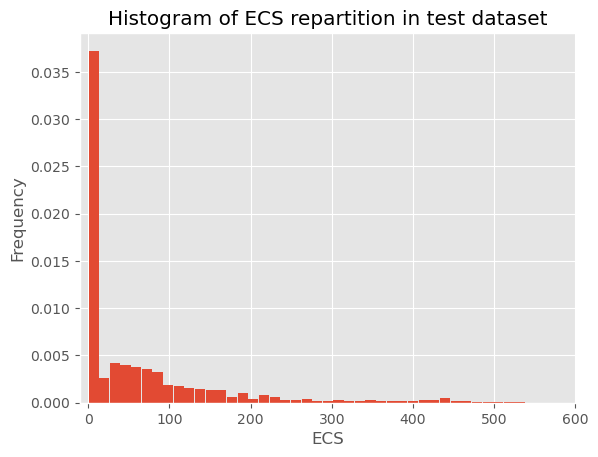

In [ ]:
plt.hist(full_batch_ecs.detach().numpy().flatten()*670.25141631,
         bins=50,
         rwidth = 0.95,
         density = True)  
plt.title('Histogram of ECS repartition in test dataset')
plt.xlabel('ECS')
plt.ylabel('Frequency')
plt.xlim(-10, 601)
plt.show()

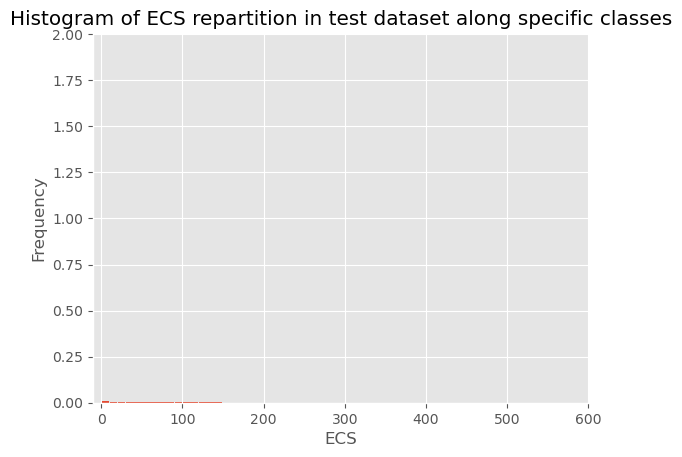

In [ ]:
plt.hist(full_batch_ecs.detach().numpy().flatten()*670.25141631,
         bins=[-0.1,0.1,10,20,30,40,50,60,70,80,90,100,120,150,200,250,300,700],
         rwidth = 0.95,
         density = True)  
plt.title('Histogram of ECS repartition in test dataset along specific classes')
plt.xlabel('ECS')
plt.ylabel('Frequency')
plt.xlim(-10, 601)
plt.show()

In [ ]:
def get_AP_global_rmse(acoustic_predictor, dm_dict, phase = 'test', device = 'cpu'):

    ecs_rmse_from_ap = []

    for batch in dm_dict[phase]:
        x,y = batch
        ecs_ground_truth = y.to(device)
        ecs_from_ap = acoustic_predictor(x.to(device))
        ecs_rmse_from_ap.append(torch.sqrt(nn.MSELoss()(ecs_from_ap,ecs_ground_truth)).item()*670.25141631 )

    return np.mean(ecs_rmse_from_ap)

In [ ]:
def get_AP_RMSE_per_ecs_class(model ,dm_dict,phase = 'test', device = 'cpu', from_ae = False , verbose = True):
    ecs_class_dict = {
                    "[0,0]":[],
                    "]0,10[":[],
                    "[10,20[":[],
                    "[20,30[":[],
                    "[30,40[":[],
                    "[40,50[":[],
                    "[50,60[":[],
                    "[60,70[":[],
                    "[70,80[":[],
                    "[80,90[":[],
                    "[90,100[":[],
                    "[100,120[":[],
                    "[120,150[":[],
                    "[150,200[":[],
                    "[200,250[":[],
                    "[250,300[":[],
                    "[300,700[":[],

                }
    
    absolute_rmse_ecs_from_ap_class_dict = copy.deepcopy(ecs_class_dict)
    relative_rmse_ecs_from_ap_class_dict = copy.deepcopy(ecs_class_dict)
    

    
    for n,batch in enumerate(dm_dict[phase]):
        print(f"\nBatch: {n+1}/{len(dm_dict[phase])}")
        x,y = batch
        ecs_flatten = y.to(device).flatten()

        if from_ae:
            decoded = model(x.to(device))
            ecs_from_model = model.acoustic_predictor(decoded).flatten()
        
        else:
            ecs_from_model = model(x.to(device)).flatten()

        
        for i in tqdm(range(len(ecs_flatten)),desc='Computing ECS RMSE per ECS class', disable=not(verbose)):
            rmse_from_ap = torch.sqrt(nn.MSELoss()(ecs_flatten[i],ecs_from_model[i])).item()*670.25141631            
            ecs_ground_truth = ecs_flatten[i].item()*670.25141631
            
            
            if ecs_ground_truth == 0:
                absolute_rmse_ecs_from_ap_class_dict["[0,0]"].append(rmse_from_ap)
                relative_rmse_ecs_from_ap_class_dict["[0,0]"].append(np.nan)


            
            elif 0 < ecs_ground_truth < 10:
                absolute_rmse_ecs_from_ap_class_dict["]0,10["].append(rmse_from_ap)
                relative_rmse_ecs_from_ap_class_dict["]0,10["].append(rmse_from_ap/ecs_ground_truth)

                
            elif 10 <= ecs_ground_truth < 20:
                absolute_rmse_ecs_from_ap_class_dict["[10,20["].append(rmse_from_ap)
                relative_rmse_ecs_from_ap_class_dict["[10,20["].append(rmse_from_ap/ecs_ground_truth)

                
            elif 20 <= ecs_ground_truth < 30:
                absolute_rmse_ecs_from_ap_class_dict["[20,30["].append(rmse_from_ap)
                relative_rmse_ecs_from_ap_class_dict["[20,30["].append(rmse_from_ap/ecs_ground_truth)

            elif 30 <= ecs_ground_truth < 40:
                absolute_rmse_ecs_from_ap_class_dict["[30,40["].append(rmse_from_ap)
                relative_rmse_ecs_from_ap_class_dict["[30,40["].append(rmse_from_ap/ecs_ground_truth)

                
            elif 40 <= ecs_ground_truth < 50:
                absolute_rmse_ecs_from_ap_class_dict["[40,50["].append(rmse_from_ap)
                relative_rmse_ecs_from_ap_class_dict["[40,50["].append(rmse_from_ap/ecs_ground_truth)

                
            elif 50 <= ecs_ground_truth < 60:
                absolute_rmse_ecs_from_ap_class_dict["[50,60["].append(rmse_from_ap)
                relative_rmse_ecs_from_ap_class_dict["[50,60["].append(rmse_from_ap/ecs_ground_truth)
                
            elif 60 <= ecs_ground_truth < 70:
                absolute_rmse_ecs_from_ap_class_dict["[60,70["].append(rmse_from_ap)
                relative_rmse_ecs_from_ap_class_dict["[60,70["].append(rmse_from_ap/ecs_ground_truth)

                
            elif 70 <= ecs_ground_truth < 80:
                absolute_rmse_ecs_from_ap_class_dict["[70,80["].append(rmse_from_ap)
                relative_rmse_ecs_from_ap_class_dict["[70,80["].append(rmse_from_ap/ecs_ground_truth)
                
            elif 80 <= ecs_ground_truth < 90:
                absolute_rmse_ecs_from_ap_class_dict["[80,90["].append(rmse_from_ap)
                relative_rmse_ecs_from_ap_class_dict["[80,90["].append(rmse_from_ap/ecs_ground_truth)
                
            elif 90 <= ecs_ground_truth < 100:
                absolute_rmse_ecs_from_ap_class_dict["[90,100["].append(rmse_from_ap)
                relative_rmse_ecs_from_ap_class_dict["[90,100["].append(rmse_from_ap/ecs_ground_truth)
                
            elif 100 <= ecs_ground_truth < 120:
                absolute_rmse_ecs_from_ap_class_dict["[100,120["].append(rmse_from_ap)
                relative_rmse_ecs_from_ap_class_dict["[100,120["].append(rmse_from_ap/ecs_ground_truth)

                
            elif 120 <= ecs_ground_truth < 150:
                absolute_rmse_ecs_from_ap_class_dict["[120,150["].append(rmse_from_ap)
                relative_rmse_ecs_from_ap_class_dict["[120,150["].append(rmse_from_ap/ecs_ground_truth)

                
            elif 150 <= ecs_ground_truth < 200:
                absolute_rmse_ecs_from_ap_class_dict["[150,200["].append(rmse_from_ap)
                relative_rmse_ecs_from_ap_class_dict["[150,200["].append(rmse_from_ap/ecs_ground_truth)

                
            elif 200 <= ecs_ground_truth < 250:
                absolute_rmse_ecs_from_ap_class_dict["[200,250["].append(rmse_from_ap)
                relative_rmse_ecs_from_ap_class_dict["[200,250["].append(rmse_from_ap/ecs_ground_truth)
                
            elif 250 <= ecs_ground_truth < 300:
                absolute_rmse_ecs_from_ap_class_dict["[250,300["].append(rmse_from_ap)
                relative_rmse_ecs_from_ap_class_dict["[250,300["].append(rmse_from_ap/ecs_ground_truth)

                
            elif 300 <= ecs_ground_truth < 700:
                absolute_rmse_ecs_from_ap_class_dict["[300,700["].append(rmse_from_ap)
                relative_rmse_ecs_from_ap_class_dict["[300,700["].append(rmse_from_ap/ecs_ground_truth)
                
        
    return dict(absolute_rmse =absolute_rmse_ecs_from_ap_class_dict, relative_rmse = relative_rmse_ecs_from_ap_class_dict)
            
                
        

In [ ]:

def get_AP_error_global(dm_dict, model_ap_list = [], model_ae_list = [], ecs_class = True, phase = 'test', device = 'cpu', verbose = True):
    
    global_rmse_dict = {}
    ecs_class_rmse_dict = {}
    for model_ap_path in model_ap_list:
        
        if model_ap_path[-5:] != '.ckpt':
            
            model_ap_path_list = glob.glob(f"{model_ap_path}/**/*.ckpt",recursive=True)
            
            if len(model_ap_path_list) == 0:
                print("Error while loading model: {model_ap_path}, \n Could not find a chekpoint file.")
                continue
            
            else:
                model_ap_path = model_ap_path_list[-1]
                ##* load the last available chekpoint if none is precised
        
            
        ap_arch_shape = model_ap_path.split('/')[-4]
        
        
        try:
            acoustic_predictor = AcousticPredictor.load_from_checkpoint(checkpoint_path = model_ap_path,
                                                                        input_depth= 107,
                                                                        arch_shape = ap_arch_shape).to(device)
        
        except:
            print(f"Could not load model {model_ap_path}")
            continue
        
        
        if verbose:
            print(f"\nComputing RMSE for Acoustic Predictor: {ap_arch_shape}:")
            
            
        key =f"AP_{ap_arch_shape}"   
        global_rmse_dict[key] = get_AP_global_rmse(acoustic_predictor, dm_dict, phase, device)
        
        
        if verbose:
            print(f"\tECS RMSE over {phase} batches: {np.round(global_rmse_dict[key],2)}m")
        
        
        if ecs_class:
            if verbose:
                print(f"\tComputing RMSE per {phase} batches and per ECS class:")
            ecs_class_rmse_dict[f"AP_{ap_arch_shape}"] = get_AP_RMSE_per_ecs_class(acoustic_predictor, dm_dict, phase, device,from_ae= False, verbose = verbose)
            
            
            
            
            
            
    for model_ae_path in model_ae_list:
    
        if model_ae_path[-5:] != '.ckpt':
            
            model_ae_path_list = glob.glob(f"{model_ae_path}/**/*.ckpt",recursive=True)
            
            if len(model_ae_path_list) == 0:
                print(f"Error while loading model: {model_ae_path}, \n Could not find a chekpoint file.")
                continue
            
            else:
                model_ae_path = model_ae_path_list[-1]
                ##* load the last available chekpoint if none is precised
                
        config_ae_path = get_config_file_path_from_ckpt_path(model_ae_path)
                
        with open(config_ae_path, 'r') as file:
            ae_config = yaml.safe_load(file)
            
        ap_path = ae_config['paths']['acc_model_path']
        
        ap_config = get_config_file_path_from_ckpt_path(ap_path)
        
        ap_arch_shape = ap_config["model"]['arch_shape']
        accoustic_training = ae_config['model']['accoustic_training']
        arch_shape_ae = ae_config['model']['arch_shape']
        
        try:
            acoustic_predictor = AcousticPredictor.load_from_checkpoint(checkpoint_path = ap_path, input_depth= 107, arch_shape = ap_arch_shape).to(device)
            acoustic_predictor.eval()
                    

            model_ae = AutoEncoder.load_from_checkpoint(model_ae_path,
                                                        x_min = x_min, 
                                                        x_max = x_max,
                                                        arch_shape = arch_shape_ae,
                                                        acoustic_predictor= copy.deepcopy(acoustic_predictor), 
                                                        accoustic_training = accoustic_training
                                                        ).to(device)
        
        except:
            if verbose:
                print(f"Could not load model {model_ae_path}")
            continue
        
        if verbose:
            print(f"\nComputing RMSE for Acoustic Predictor: {arch_shape_ae}:")
            
        key = f"AP_from_AE_{arch_shape_ae}"
        global_rmse_dict[key] = get_AP_global_rmse(model_ae.acoustic_predictor, dm_dict, phase, device)
        
        if verbose:
            print(f"\tECS RMSE over {phase} batches: {np.round(global_rmse_dict[key],2)}m")
        
        if ecs_class:
            if verbose:
                print(f"\tComputing RMSE per {phase} batches and per ECS class:")
            ecs_class_rmse_dict[f"AP_from_AE_{arch_shape_ae}"] = get_AP_RMSE_per_ecs_class(model_ae.acoustic_predictor, dm_dict, phase, device, from_ae= True, verbose = verbose)
    
    
    return global_rmse_dict, ecs_class_rmse_dict

In [ ]:
model_ap_list = [
    "/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/accoustic_predictor_50/dense_2D_CNN_ReLu/pred_weight_1_classif_weight_0_2024-05-18_13-25",
    ]

 
ae_dir_path = "/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_without_AP"
model_ae_list = glob.glob(f"{ae_dir_path}/**/*.ckpt", recursive=True)


In [ ]:
global_rmse_dict, ecs_class_rmse_dict = get_AP_error_global(dm_dict, model_ap_list = model_ap_list[:1], model_ae_list = [], ecs_class = True, verbose=True)


Computing RMSE for Acoustic Predictor: dense_2D_CNN_ReLu:
	ECS RMSE over test batches: 95.09m
	Computing RMSE per test batches and per ECS class:

Batch: 1/9


Computing ECS RMSE per ECS class: 100%|██████████| 230400/230400 [00:09<00:00, 24751.96it/s]



Batch: 2/9


Computing ECS RMSE per ECS class: 100%|██████████| 230400/230400 [00:09<00:00, 25085.11it/s]



Batch: 3/9


Computing ECS RMSE per ECS class: 100%|██████████| 230400/230400 [00:09<00:00, 25275.15it/s]



Batch: 4/9


Computing ECS RMSE per ECS class: 100%|██████████| 230400/230400 [00:09<00:00, 25083.29it/s]



Batch: 5/9


Computing ECS RMSE per ECS class: 100%|██████████| 230400/230400 [00:09<00:00, 25149.83it/s]



Batch: 6/9


Computing ECS RMSE per ECS class: 100%|██████████| 230400/230400 [00:09<00:00, 25315.25it/s]



Batch: 7/9


Computing ECS RMSE per ECS class: 100%|██████████| 230400/230400 [00:09<00:00, 24881.95it/s]



Batch: 8/9


Computing ECS RMSE per ECS class: 100%|██████████| 230400/230400 [00:09<00:00, 25046.35it/s]



Batch: 9/9


Computing ECS RMSE per ECS class: 100%|██████████| 230400/230400 [00:09<00:00, 25297.19it/s]


/tmp/ipykernel_4137507/840399329.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ecs_class)
/tmp/ipykernel_4137507/840399329.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ecs_class)
/tmp/ipykernel_4137507/840399329.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ecs_class)
/tmp/ipykernel_4137507/840399329.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ecs_class)


Text(0.5, 1.0, 'Median of the relative RMSE per ECS class')

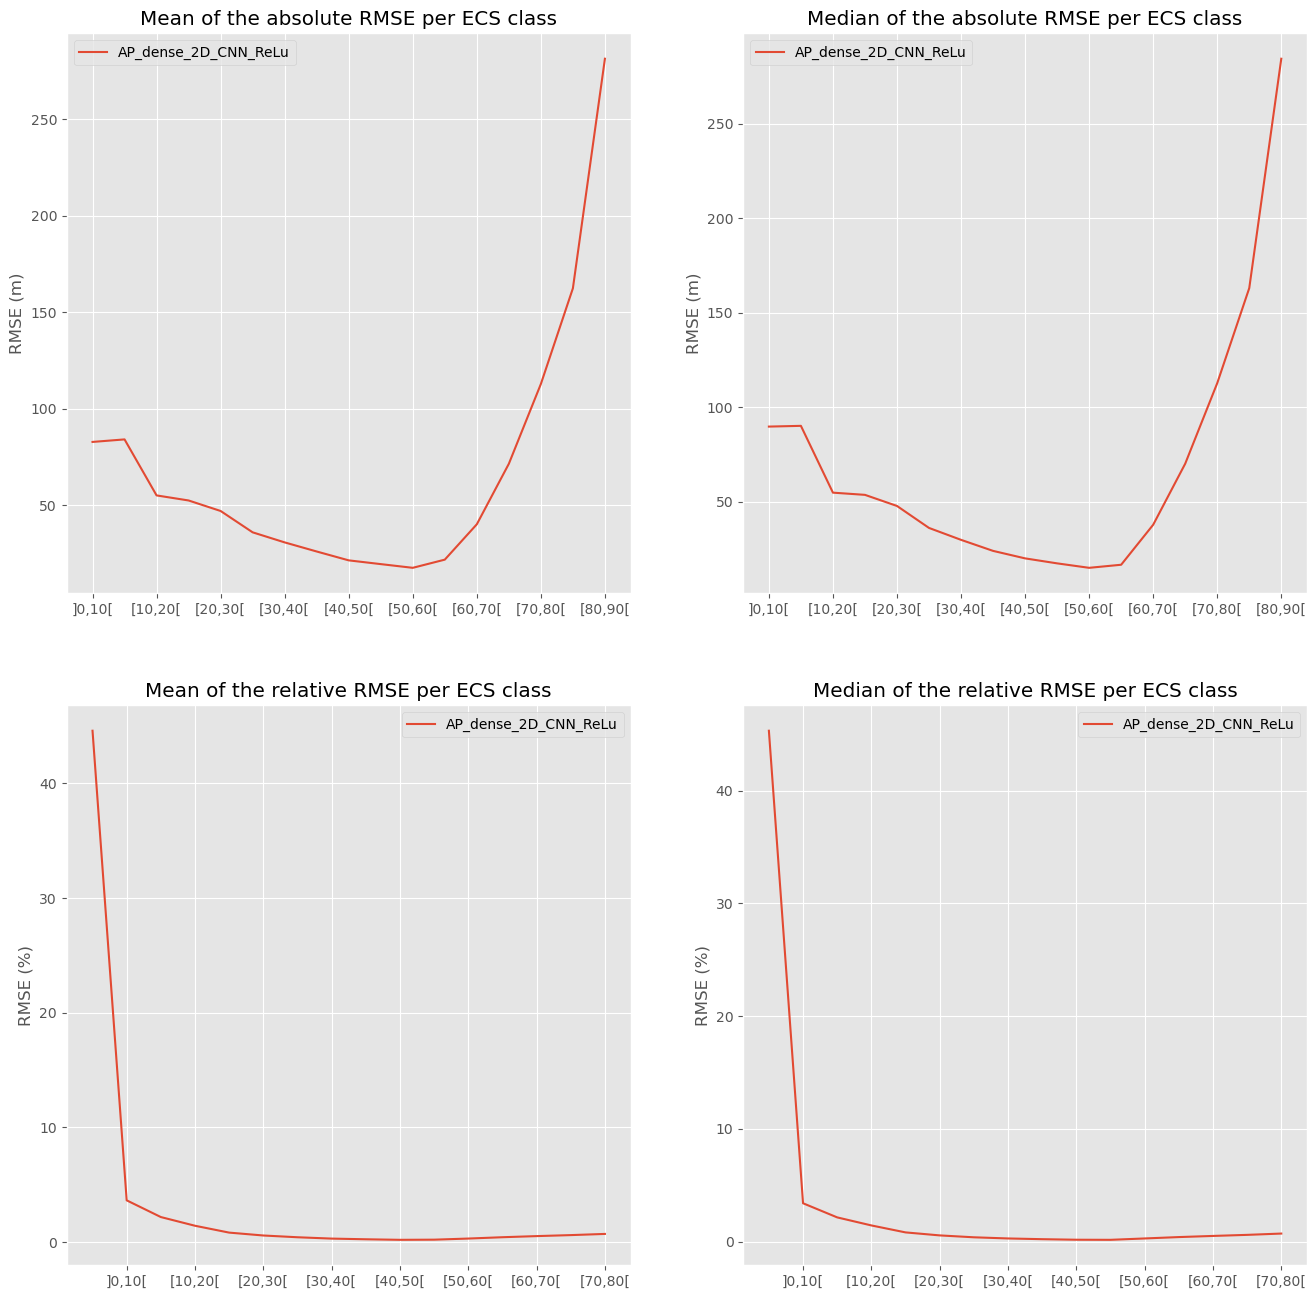

In [ ]:
fig,axs = plt.subplots(2,2,figsize = (16,16))
#xticks_labels = list(ecs_class_rmse_dict.values()[0])
#n = len(xticks_labels)
for ap_shape, tuple_rmse in ecs_class_rmse_dict.items():
    
    absolute_rmse_ecs_means = [np.mean(rmse_list) for rmse_list in tuple_rmse["absolute_rmse"].values()]
    absolute_rmse_ecs_medians = [np.median(rmse_list) for rmse_list in tuple_rmse["absolute_rmse"].values()]


    relative_rmse_ecs_means = [np.mean(rmse_list) for rmse_list in tuple_rmse["relative_rmse"].values()]
    relative_rmse_ecs_medians = [np.median(rmse_list) for rmse_list in tuple_rmse["relative_rmse"].values()]
    
    n = len(absolute_rmse_ecs_means)
    
    axs[0,0].plot(np.arange(n),absolute_rmse_ecs_means, label=ap_shape)
    axs[0,1].plot(np.arange(n),absolute_rmse_ecs_medians, label=ap_shape)

    axs[1,0].plot(np.arange(n),relative_rmse_ecs_means, label=ap_shape)
    axs[1,1].plot(np.arange(n),relative_rmse_ecs_medians, label=ap_shape)


ecs_class = tuple_rmse["absolute_rmse"].keys()


for ax in axs[0,:]:

    ax.legend()
    ax.set_ylabel("RMSE (m)")
    ax.set_xticklabels(ecs_class)
    #ax.xaxis.set_tick_params(rotation=45)
    
for ax in axs[1,:]:

    ax.legend()
    ax.set_ylabel("RMSE (%)")
    ax.set_xticklabels(ecs_class)
    
    
    
axs[0,0].set_title("Mean of the absolute RMSE per ECS class")
axs[0,1].set_title("Median of the absolute RMSE per ECS class")
axs[1,0].set_title("Mean of the relative RMSE per ECS class")
axs[1,1].set_title("Median of the relative RMSE per ECS class")


# Error ECS classification

In [4]:
# dm_dict_classif = generate_dataloader_classif(sound_speed_path,
#                                               ecs_classif_path,
#                                               dl_kw,
#                                               x_min,
#                                               x_max)

In [8]:
model_ecs_classif_path = "/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/ecs_classif/UNet_3D/2024-06-05_21-19/checkpoints/val_loss=21.43-epoch=04.ckpt"

In [9]:
cfg = get_cfg_from_from_ckpt_path(model_ecs_classif_path, pprint = True)


```yaml

datamodule:
  _target_: src.data.BaseDatamodule_ecs_classif
  dl_kw: {batch_size: '${model_config.batch_size.${dimensions}}', num_workers: 4}
  dtype_str: ${dtype}
  input_da: {_target_: src.utils.load_ssf_ecs_classif_da, ecs_classif_da_path: '${model_config.ECS_classif_path.${model.model_name}}',
    ssf_da_path: '${ssp_path}'}
  model_name: ${model.model_name}
  x_max: ${normalization.x_max}
  x_min: ${normalization.x_min}
dimensions: 3D
dtype: float32
entrypoints:
- {_target_: pytorch_lightning.seed_everything, seed: 333}
- {_target_: src.train.base_training, dm: '${datamodule}', lit_mod: '${model}', trainer: '${trainer}'}
model:
  _target_: src.ecs_classification.ECS_classification
  depth_array: {_target_: src.utils.get_depth_array, ssf_da_path: '${ssp_path}'}
  loss_weight: ${model_config.loss_weight.${model.model_name}}
  model_hparams: ${model_config.model_hparams.${model.model_name}}
  model_name: ${model_architecture}_${dimensions}
  opt_fn: {T_max: '${trainer.max_epochs}', _partial_: true, _target_: src.ecs_classification.ECS_classification.cosanneal_lr_adamw,
    lr: 0.001, weight_decay: 0.01}
model_architecture: UNet
model_config:
  ECS_classif_path: {CNN_2D: /DATASET/envs/o23gauvr/tmp/eNATL60_BLB002_ECS_2D_binary_classification_at_0_regrid_0_1000m.nc,
    CNN_3D: /DATASET/envs/o23gauvr/tmp/eNATL60_BLB002_ECS_2D_binary_classification_at_0_regrid_0_1000m.nc,
    UNet_2D: /DATASET/envs/o23gauvr/tmp/eNATL60_BLB002_ECS_2D_binary_classification_at_0_regrid_0_1000m.nc,
    UNet_3D: /DATASET/envs/o23gauvr/tmp/eNATL60_BLB002_ECS_3D_binary_classification_at_0_regrid_0_1000m.nc}
  accumulate_grad_batches: {2D: 1, 3D: 4}
  batch_size: {2D: 4, 3D: 1}
  loss_weight: {CNN_2D: 0.5, CNN_3D: 0.5, UNet_2D: 0.5, UNet_3D: 145.0}
  model_hparams:
    CNN_2D:
      avg_pool: false
      batch_norm: true
      channels_start: 20
      dtype_str: ${dtype}
      final_act_func_str: Sigmoid
      in_ch: 107
      num_classes: 1
      num_layers: 4
      spatial_dim: [240, 240]
    CNN_3D:
      avg_pool: false
      batch_norm: true
      channels_start: 20
      dtype_str: ${dtype}
      final_act_func_str: Sigmoid
      in_ch: 3
      num_classes: 1
      num_layers: 4
      spatial_dim: [240, 240]
    UNet_2D: {avg_pool: false, batch_norm: true, bilinear: false, dtype_str: '${dtype}',
      features_start: 64, final_act_func_str: Sigmoid, in_ch: 107, num_classes: 1,
      num_layers: 5}
    UNet_3D: {avg_pool: false, batch_norm: true, bilinear: false, dtype_str: '${dtype}',
      features_start: 64, final_act_func_str: Sigmoid, in_ch: 3, num_classes: 1, num_layers: 5}
normalization: {x_max: 1545.8698054910844, x_min: 1459.0439165829073}
ssp_path: /DATASET/eNATL/eNATL60_BLB002_sound_speed_regrid_0_1000m.nc
trainer:
  _target_: pytorch_lightning.Trainer
  accelerator: gpu
  accumulate_grad_batches: ${model_config.accumulate_grad_batches.${dimensions}}
  callbacks:
  - {_target_: pytorch_lightning.callbacks.LearningRateMonitor}
  - {_target_: pytorch_lightning.callbacks.ModelCheckpoint, filename: '{val_loss:.2f}-{epoch:02d}',
    mode: min, monitor: val_loss, save_top_k: 1}
  - {_target_: pytorch_lightning.callbacks.EarlyStopping, check_on_train_epoch_end: true,
    min_delta: 0.0, monitor: val_loss, patience: 3, verbose: true}
  check_val_every_n_epoch: 1
  devices: 1
  inference_mode: false
  logger: {_target_: pytorch_lightning.loggers.tensorboard.TensorBoardLogger, name: '${model.model_name}',
    save_dir: "/homes/o23gauvr/Documents/th\xE8se/code/FASCINATION/outputs/ecs_classif/",
    version: '${now:%Y-%m-%d_%H-%M}'}
  max_epochs: 1000
  min_epochs: 0


```

In [10]:
dm = hydra.utils.call(cfg.datamodule) # will instantiate src.data.BaseDataModule with parameters specified in config
dm.setup(stage="test") # setup the datamodule see https://lightning.ai/docs/pytorch/stable/data/datamodule.html#lightningdatamodule-api

In [11]:
lit_mod =  hydra.utils.call(cfg.model)
lit_mod.load_state_dict(torch.load(model_ecs_classif_path)["state_dict"]) 
lit_mod

ECS_classification(
  (model): UNet_3D(
    (layers): ModuleList(
      (0): DoubleConv(
        (net): Sequential(
          (0): Conv3d(3, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv3d(64, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 1, 1))
          (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU(inplace=True)
        )
      )
      (1): Down(
        (net): Sequential(
          (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (1): DoubleConv(
            (net): Sequential(
              (0): Conv3d(64, 128, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 1, 1))
              (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
    

In [12]:
lit_mod = lit_mod.to('cuda:2') # Move model to gpu for faster inference
lit_mod = lit_mod.eval() # Model in eval mode

for param in lit_mod.parameters():
    param.requires_grad = False  # Ensure no gradients are calculated for this model

In [13]:
test_dl = dm.test_dataloader()

In [14]:
ssf_input, ecs_classif_truth = test_dl.dataset.input.data, test_dl.dataset.tgt.data
ssf_input, ecs_classif_truth  = torch.tensor(ssf_input).to(lit_mod.device), torch.tensor(ecs_classif_truth).to(lit_mod.device) 

In [15]:
print(len(torch.nonzero(torch.isnan(ecs_classif_truth.view(-1)))))
print(len(torch.nonzero(torch.isnan(ssf_input.view(-1)))))

0
9049716


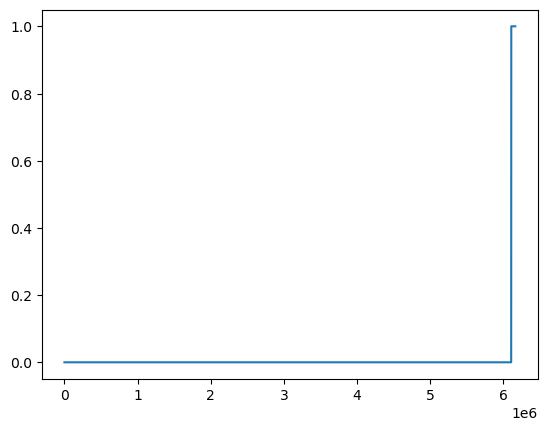

In [35]:

plt.plot(np.sort(ecs_classif_truth[0,:,:,:].flatten().cpu().detach().numpy()))

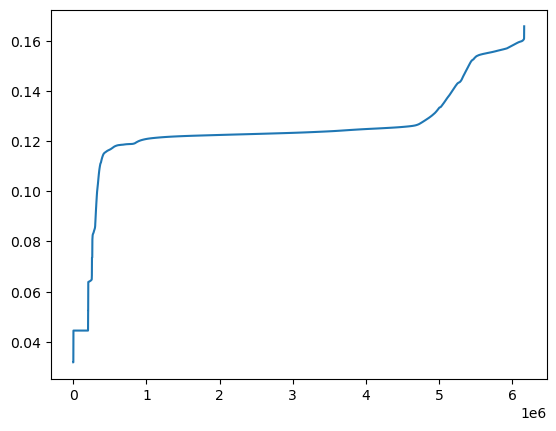

In [36]:
plt.plot(np.sort(ecs_classif[0,:,:,:].flatten().cpu().detach().numpy()))

In [22]:
ecs_classif_list = []
for batch_test in tqdm(test_dl):
    batch_test = lit_mod.transfer_batch_to_device(batch_test, lit_mod.device, 0)
    ssf_input_batch, ecs_classif_truth_batch = batch_test
    with torch.no_grad():
        ecs_classif_list.append(lit_mod(torch.nan_to_num(ssf_input_batch.float())))
        
        
ecs_classif = torch.cat(ecs_classif_list,dim=0)
del ecs_classif_list


#predicted_classes = torch.argmax(ecs_classif, dim = 1)
print(accuracy_score(ecs_classif_truth.flatten().cpu().detach().numpy(),ecs_classif.flatten().cpu().detach().numpy()))
print(len(torch.nonzero(torch.isnan(ecs_classif.reshape(-1)))))

torch.cuda.empty_cache()

        

100%|██████████| 36/36 [00:12<00:00,  2.89it/s]


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [ ]:
ecs_classif_list = []
for batch_test in tqdm(test_dl):
    batch_test = lit_mod.transfer_batch_to_device(batch_test, lit_mod.device, 0)
    ssf_input_batch, ecs_classif_truth_batch = batch_test
    with torch.no_grad():
        ecs_classif_list.append(lit_mod(ssf_input_batch.float()))
        
        
ecs_classif = torch.cat(ecs_classif_list,dim=0)
del ecs_classif_list


#predicted_classes = torch.argmax(ecs_classif, dim = 1)
print(accuracy_score(ecs_classif_truth.flatten().cpu().detach().numpy(),predicted_classes.flatten().cpu().detach().numpy()))
print(len(torch.nonzero(torch.isnan(ecs_classif.reshape(-1)))))

torch.cuda.empty_cache()


100%|██████████| 36/36 [00:12<00:00,  2.86it/s]


0.9941219207915081
0


In [ ]:
torch.isnan(ssf_input).nonzero(as_tuple=True)

(tensor([ 0,  0,  0,  ..., 35, 35, 35], device='cuda:2'),
 tensor([  0,   0,   0,  ..., 106, 106, 106], device='cuda:2'),
 tensor([229, 229, 229,  ..., 239, 239, 239], device='cuda:2'),
 tensor([  8,   9,  10,  ..., 139, 140, 141], device='cuda:2'))

In [ ]:
ssf_input[0,:,229,8]

tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       device='cuda:2', dtype=torch.float64)

In [ ]:
#plt.plot(ecs_classif[0,1,:,25,25].cpu().detach().numpy() + ecs_classif[0,0,:,25,25].cpu().detach().numpy() )

In [ ]:
predicted_classes = torch.argmax(ecs_classif, dim = 1)

In [ ]:
(predicted_classes == 0).all()

tensor(True, device='cuda:2')

In [ ]:
peaks_indices = (predicted_classes == 1).nonzero(as_tuple=True)
peaks_indices

(tensor([], device='cuda:2', dtype=torch.int64),
 tensor([], device='cuda:2', dtype=torch.int64),
 tensor([], device='cuda:2', dtype=torch.int64),
 tensor([], device='cuda:2', dtype=torch.int64))

In [ ]:
(ecs_classif_truth == 1).nonzero(as_tuple=True)

(tensor([ 0,  0,  0,  ..., 35, 35, 35], device='cuda:2'),
 tensor([ 1,  1,  1,  ..., 74, 74, 74], device='cuda:2'),
 tensor([127, 128, 128,  ..., 239, 239, 239], device='cuda:2'),
 tensor([ 13,  12,  13,  ..., 102, 103, 104], device='cuda:2'))

In [ ]:
ecs_one_sorted = np.sort(ecs_classif[:,1,:,:].flatten().cpu().detach().numpy())

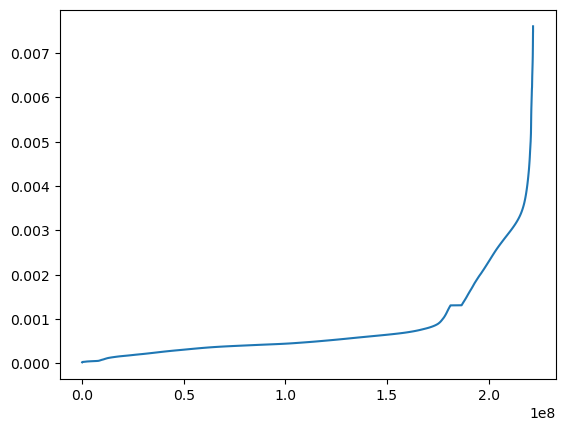

In [ ]:
plt.plot(ecs_one_sorted)

In [ ]:
ecs_one_sorted.min()

2.1132386e-05

In [ ]:
ecs_truth_sorted = np.sort(ecs_classif_truth.flatten().cpu().detach().numpy())

Text(0.5, 1.0, 'ECS existence truth')

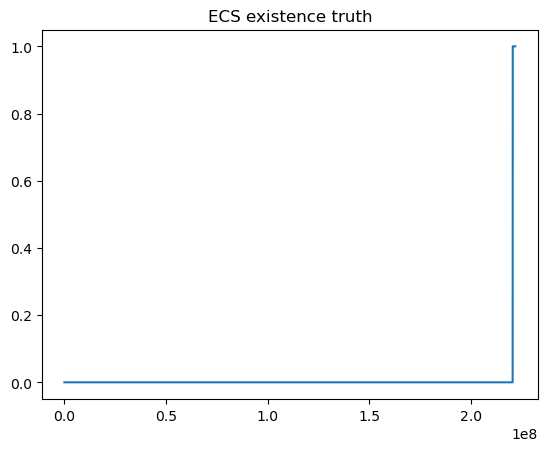

In [ ]:
plt.plot(ecs_truth_sorted)
plt.title("ECS existence truth")

In [ ]:
ecs_one_sorted = np.sort(ecs_classif[:,1,:,:].flatten().cpu().detach().numpy())
ecs_zero_sorted = np.sort(ecs_classif[:,0,:,:].flatten().cpu().detach().numpy())
ecs_truth_sorted = np.sort(ecs_classif_truth.flatten().cpu().detach().numpy())

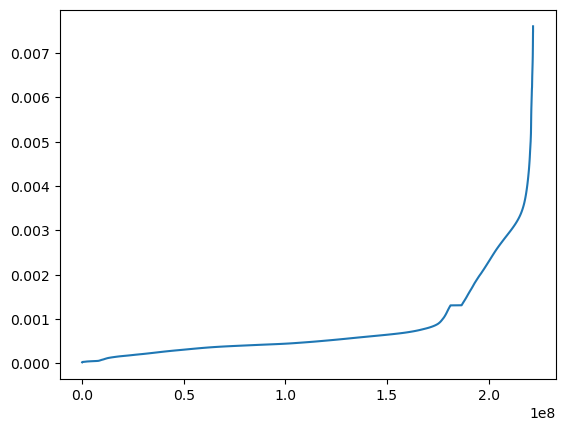

In [ ]:
plt.plot(ecs_one_sorted)

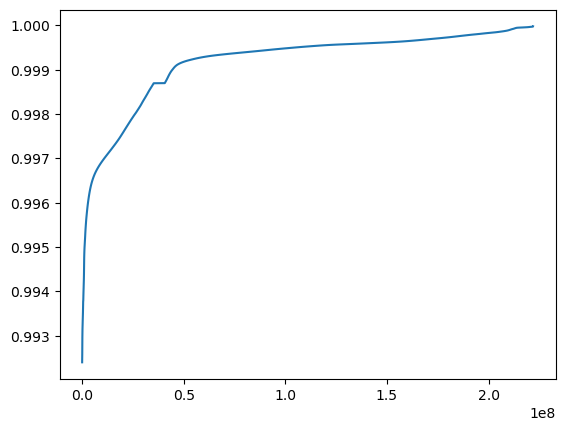

In [ ]:
plt.plot(ecs_zero_sorted)

Text(0.5, 1.0, 'ECS classification model')

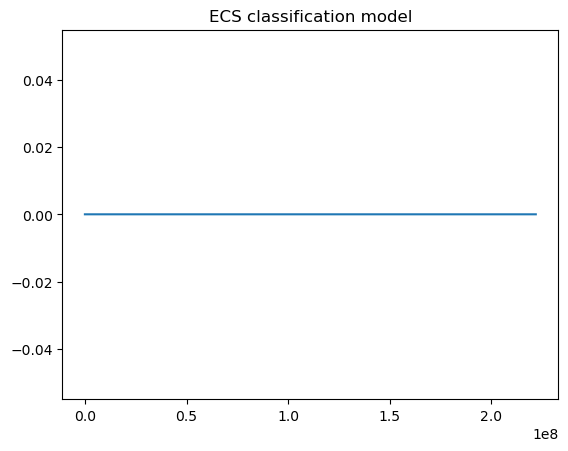

In [ ]:
plt.plot(np.sort(predicted_classes.flatten().cpu().detach().numpy()))
plt.title("ECS classification model")

In [ ]:
(predicted_classes == 0).nonzero(as_tuple=True)

(tensor([ 0,  0,  0,  ..., 35, 35, 35], device='cuda:2'),
 tensor([  0,   0,   0,  ..., 106, 106, 106], device='cuda:2'),
 tensor([  0,   0,   0,  ..., 239, 239, 239], device='cuda:2'),
 tensor([  0,   1,   2,  ..., 237, 238, 239], device='cuda:2'))

In [ ]:
(predicted_classes == 1).nonzero(as_tuple=True)

(tensor([], device='cuda:2', dtype=torch.int64),
 tensor([], device='cuda:2', dtype=torch.int64),
 tensor([], device='cuda:2', dtype=torch.int64),
 tensor([], device='cuda:2', dtype=torch.int64))

In [ ]:
ecs_classif[35,:,238,239]

IndexError: index 238 is out of bounds for dimension 2 with size 107

In [ ]:
print(np.count_nonzero(np.isnan(ecs_zero_sorted)))
print(np.count_nonzero(np.isnan(ecs_one_sorted)))
print(np.count_nonzero(np.isnan(ecs_classif_truth.flatten().cpu().detach().numpy())))


0
0
0


In [ ]:
import seaborn as sns

from sklearn.metrics import confusion_matrix


cm = confusion_matrix(ecs_classif_truth.flatten().cpu().detach().numpy(), predicted_classes.flatten().cpu().detach().numpy(), normalize = 'true')
cm

array([[1., 0.],
       [1., 0.]])

[Text(0, 0.5, 'No ECS'), Text(0, 1.5, 'ECS')]

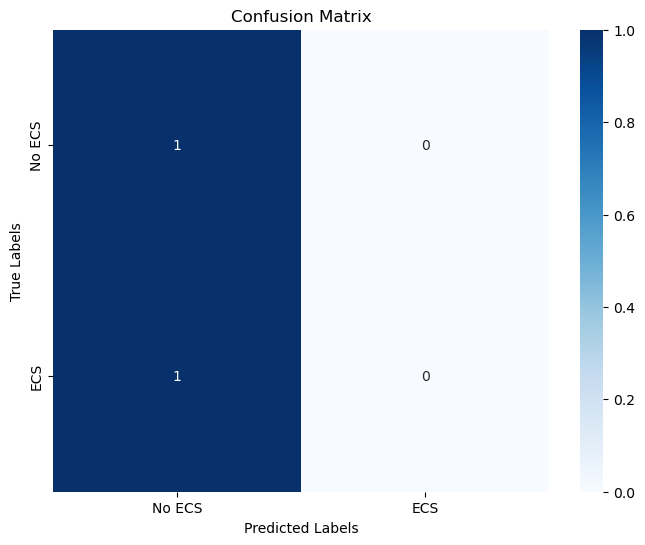

In [ ]:
class_names = ['No ECS', 'ECS']
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)

In [ ]:
dm.setup(stage="fit") 

In [ ]:
ratio_list = []

for i,train_batch in enumerate(dm.train_dataloader()):
    ssf_input_batch, ecs_classif_truth_batch = train_batch
    print(f"\nbatch n° {i}: ")
    print(f"\tnumber of class 0: {(ecs_classif_truth_batch == 0).sum().item()}")
    print(f"\tnumber of class 1: {(ecs_classif_truth_batch == 1).sum().item()}")
    print(f"\t ratio of class 1 over class 0: {(ecs_classif_truth_batch == 1).sum().item()/(ecs_classif_truth_batch == 0).sum().item()}")
    ratio_list.append((ecs_classif_truth_batch == 1).sum().item()/(ecs_classif_truth_batch == 0).sum().item())
    
    


batch n° 0: 
	number of class 0: 6143227
	number of class 1: 19973
	 ratio of class 1 over class 0: 0.0032512228507916114

batch n° 1: 
	number of class 0: 6156956
	number of class 1: 6244
	 ratio of class 1 over class 0: 0.0010141375056115392

batch n° 2: 
	number of class 0: 6131640
	number of class 1: 31560
	 ratio of class 1 over class 0: 0.005147073213691606

batch n° 3: 
	number of class 0: 6105927
	number of class 1: 57273
	 ratio of class 1 over class 0: 0.009379902511117477

batch n° 4: 
	number of class 0: 6105737
	number of class 1: 57463
	 ratio of class 1 over class 0: 0.00941131267200012

batch n° 5: 
	number of class 0: 6127559
	number of class 1: 35641
	 ratio of class 1 over class 0: 0.005816508661932101

batch n° 6: 
	number of class 0: 6113667
	number of class 1: 49533
	 ratio of class 1 over class 0: 0.00810201144419544

batch n° 7: 
	number of class 0: 6142748
	number of class 1: 20452
	 ratio of class 1 over class 0: 0.003329454504726549

batch n° 8: 
	number of 

In [ ]:
ratio_list

[0.0032512228507916114,
 0.0010141375056115392,
 0.005147073213691606,
 0.009379902511117477,
 0.00941131267200012,
 0.005816508661932101,
 0.00810201144419544,
 0.003329454504726549,
 0.009316922762494129,
 0.004946957056421139,
 0.009060786940364364,
 0.009356759432872256,
 0.0011182012099443888,
 0.00941131267200012,
 0.00941131267200012,
 0.009173470684322836,
 0.00860006991075251,
 0.008331265091552624,
 0.005907453968129616,
 0.004830464205849381,
 0.0038156133785402164,
 0.00941131267200012,
 0.00941131267200012,
 0.005752167404732838,
 0.00941131267200012,
 0.006175296398228092,
 0.008601390361729704,
 0.006456594109864326,
 0.00941131267200012,
 0.0010255184195387085,
 0.006942827664460222,
 0.0023481149538720153,
 0.0009567491253078252,
 0.004031798901709894,
 0.004587243443703946,
 0.00941131267200012,
 0.00941131267200012,
 0.006892982332321735,
 0.009296592395787326,
 0.0010463299028482197,
 0.008676496701818357,
 0.006535655241940423,
 0.009228995683528633,
 0.00797159780

Text(0.5, 1.0, 'Ratio of class 1 (ECS existence) over class 0 (no ECS)')

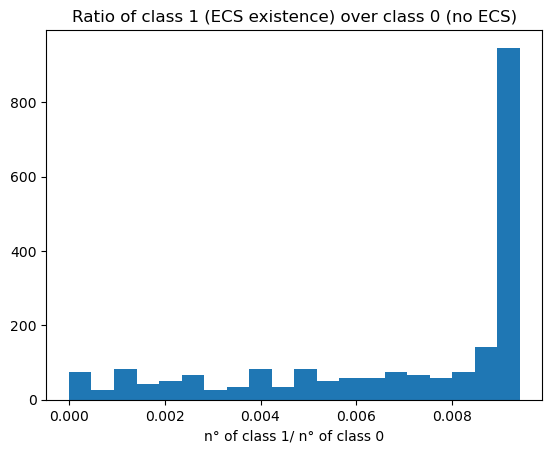

In [ ]:
plt.hist(ratio_list, bins = 20, density=True)
plt.xlabel("n° of class 1/ n° of class 0")
plt.title("Ratio of class 1 (ECS existence) over class 0 (no ECS)")

Text(0.5, 1.0, 'Ratio of class 1 (ECS existence) over class 0 (no ECS)')

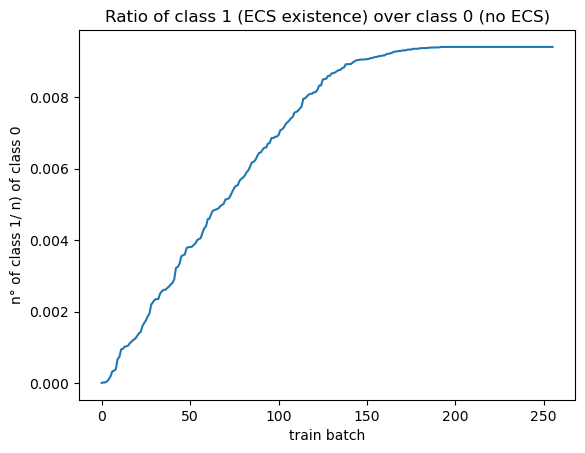

In [ ]:
plt.plot(np.sort(ratio_list))
plt.ylabel("n° of class 1/ n° of class 0")
plt.xlabel("train batch")
plt.title("Ratio of class 1 (ECS existence) over class 0 (no ECS)")